In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.stats import norm

In [6]:
# boilerplate stuff
import math
from collections.abc import Iterable

class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

def find_nearest(query, data, idx_must_be='any'):
    if idx_must_be not in ['any', 'smaller', 'greater']:
        raise ValueError('"idx_must_be" must be in [any, smaller, greater]')
    # ASSUMED A SORTED ARRAY [INCREASING] #
    # optionally, if query is inbetween elements, can pick which direction op
    if query < data[0]:
        if idx_must_be == 'smaller':
            raise ValueError('Cannot return smaller value as "query" is smaller than any datapoint')
        return 0
    elif query > data[-1]:
        if idx_must_be == 'greater':
            raise ValueError('Cannot return greater value as "query" is greater than any datapoint')
        return len(data)-1
    else:
        idx = np.searchsorted(data, query, side='left')
        if data[idx] == query:
            return idx
        elif idx_must_be == 'any':
            if abs(query - data[idx-1]) < abs(query - data[idx]):
                return idx-1
            else:
                return idx
        elif idx_must_be == 'greater':
            return idx
        elif idx_must_be == 'smaller':
            return idx - 1
        else:
            raise ValueError('invalid argument for "idx_must_be"')
            
def get_nearest_weighted_idx(query, data, sort=True):
    if sort:
        unsorted = np.array(data)
        sortidx = np.argsort(data)
        sort_reverse = {i: sortidx[i] for i in range(len(data))}

        data = np.array(data)[sortidx]
    data = list(data)
    if query in data: # exact match
        idx = [(1, data.index(query))] # weight, index
    elif query < data[0]: # before first
        idx = [(1, 0)] 
    elif query > data[-1]: # after last
        idx = [(1, len(data)-1)]
    else:
        # get nearest two elements
        i_r = np.searchsorted(data, query)
        i_l = i_r - 1
        dist = data[i_r] - query + query - data[i_l]
        idx = [(1-(data[i_r] - query)/dist, i_r), (1-(query - data[i_l])/dist, i_l)]

    # convert back to unsorted idx
    if sort:
        idx = [(w, sort_reverse[i]) for (w, i) in idx]
    return idx

In [17]:
from moxie.data.utils_ import load_data
dataset_choice='SANDBOX_NO_VARIATIONS'
file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle'

with open(file_loc, 'rb') as file:
    massive_dict = pickle.load(file)
    full_dict = massive_dict[dataset_choice]
    massive_dict = {}
train_data = full_dict['train_dict']['raw']['profiles'],full_dict['train_dict']['raw']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['raw']['radii'] ,full_dict['train_dict']['raw']['real_space_radii'] , full_dict['train_dict']['raw']['pulse_time_ids'], full_dict['train_dict']['raw']['uncerts']# , full_dict['train_dict']['padded']['elm_timings_frass']    
    

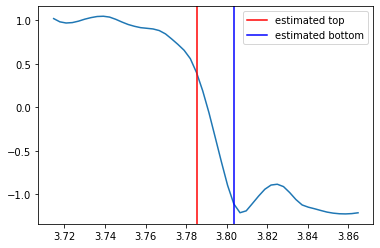

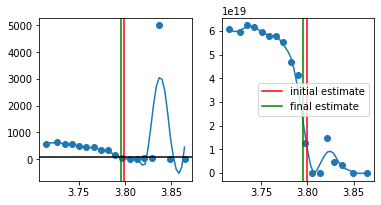

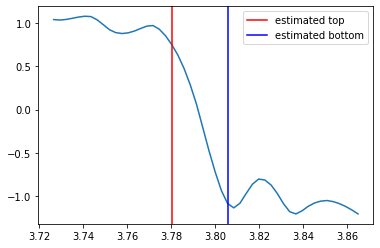

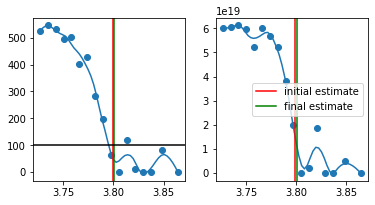

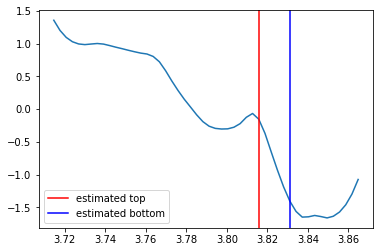

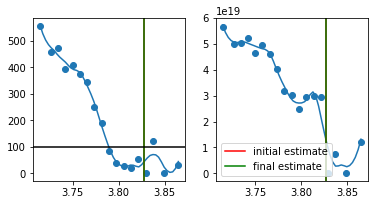

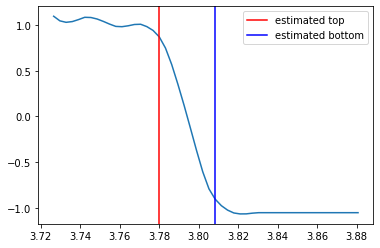

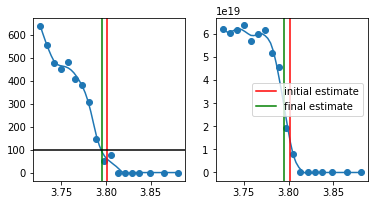

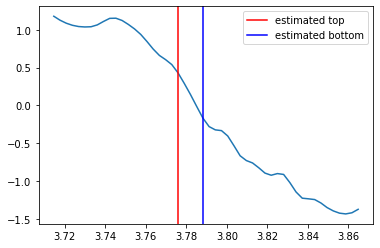

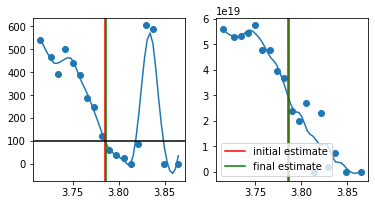

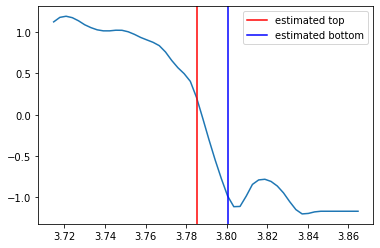

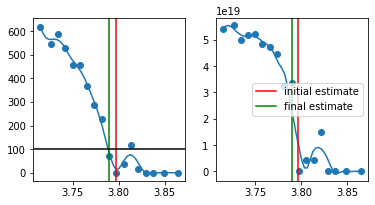

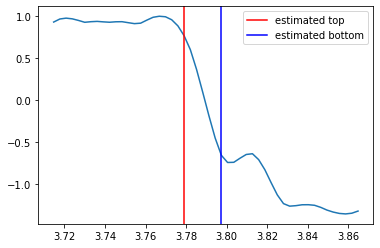

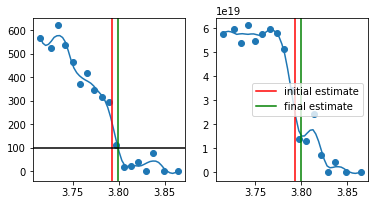

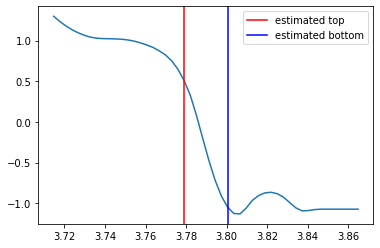

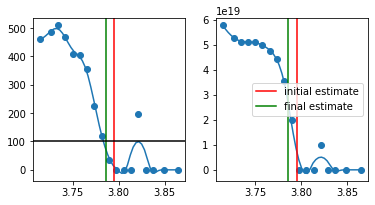

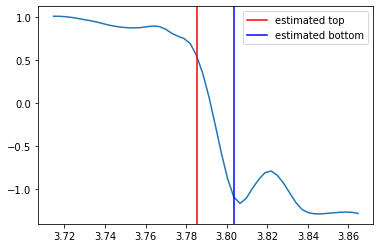

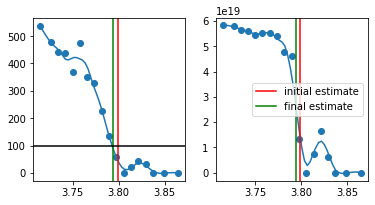

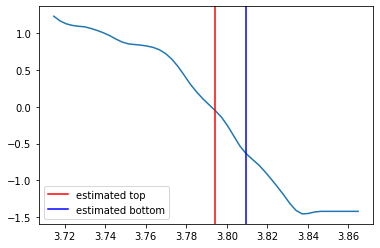

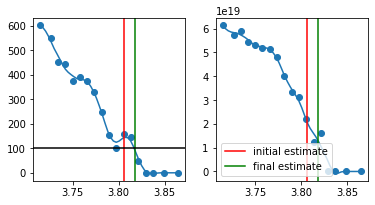

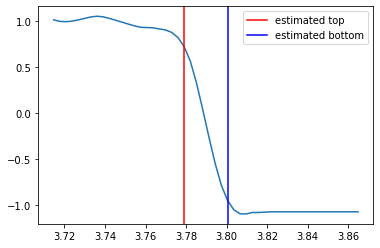

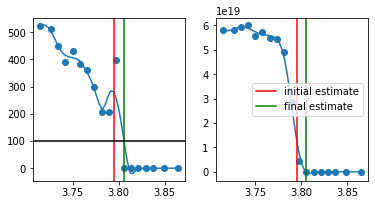

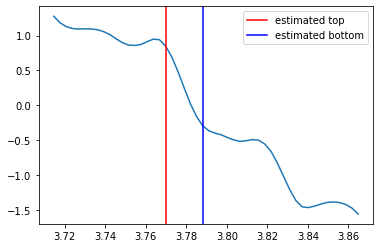

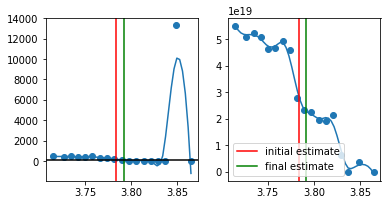

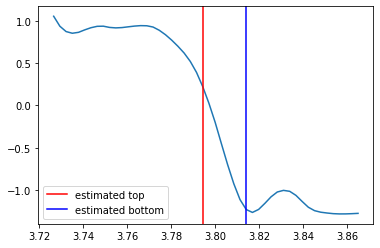

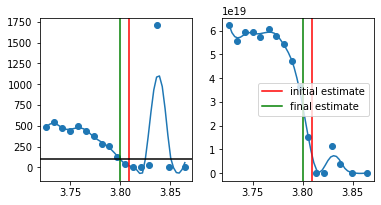

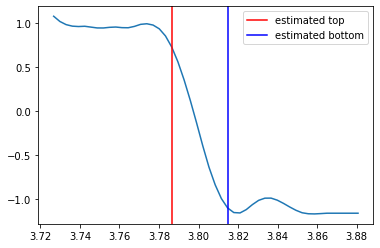

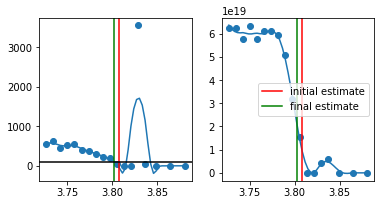

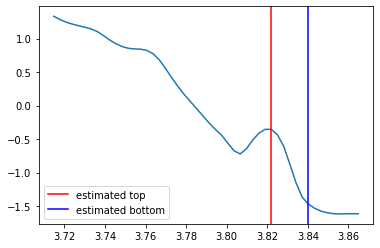

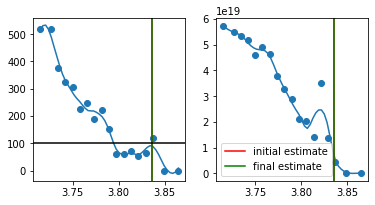

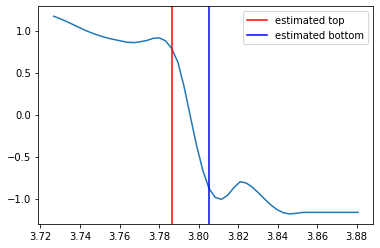

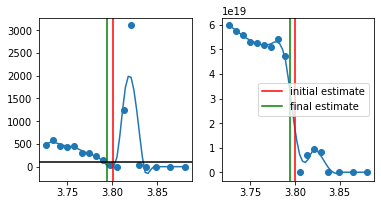

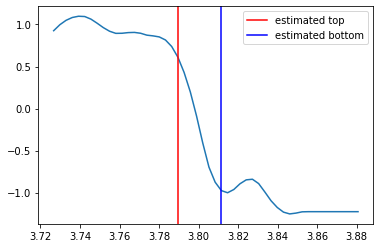

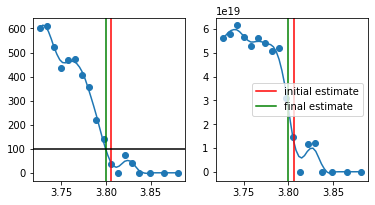

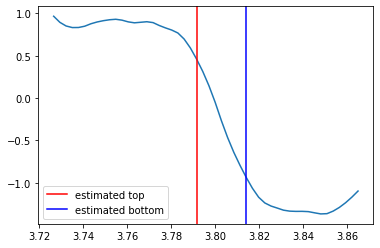

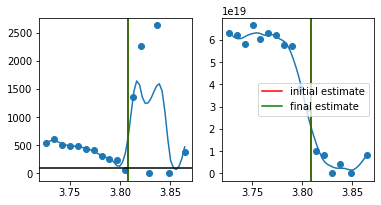

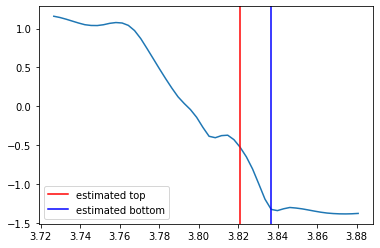

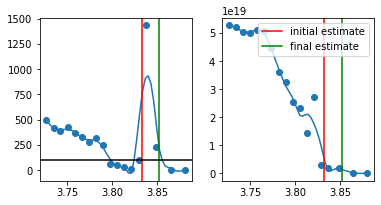

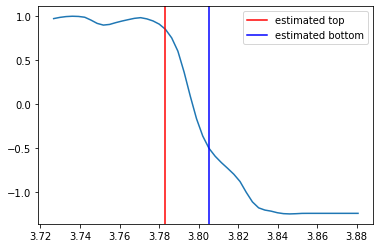

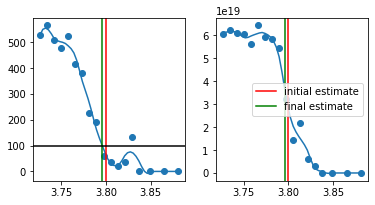

In [18]:
def pedestal_top(p, x, plot_result=False):
    # standardize signal
    p = standardize_signal(p, trim_zeros=True)

    # interp signal to Nx=50
    f_interp = interpolate.interp1d(x, p)
    x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
    p_h = f_interp(x_h)

    # smooth with savgol filter
    p_s = savgol_filter(p_h, window_length=11, polyorder=3)

    # get max gradient so we're in the pedestal
    p_s_grad = np.gradient(p_s)
    min_i = np.argmin(p_s_grad)


    # search from pedestal region outward in 2nd derivatives
    p_s_grad2 = np.gradient(p_s_grad)
    p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
    p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
    # standardize s.t. if we go >1 sd up/down, we stop searching

    # go to the left from middle point
    sd_cutoff = -.5
    start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
    min_val = p_s_grad2[min_i]
    top_i = min_i
    for i in reversed(range(0, min_i)):
        if p_s_grad2[i] < min_val:
            min_val = p_s_grad2[i]
            top_i = i
            if min_val < sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] > sd_cutoff:
            break

    # found our x for top
    # same procedure for bottom
    sd_cutoff = .5
    start_cut_early = False  # if we go > 1 for x'', etc.
    max_val = p_s_grad2[min_i]
    bottom_i = min_i

    for i in range(min_i+1, x_h.shape[0]):
        if p_s_grad2[i] > max_val:
            max_val = p_s_grad2[i]
            bottom_i = i
            if max_val > sd_cutoff:
                start_cut_early = True
        elif start_cut_early and p_s_grad2[i] < sd_cutoff:
            break

    top, bottom = x_h[top_i], x_h[bottom_i]

    if plot_result:
        plt.plot(x_h, p_s)
        plt.axvline(top, color='red', label='estimated top')
        plt.axvline(bottom, color='blue', label='estimated bottom')
        plt.legend()
        plt.show()
    return top, bottom

def find_separatrix(ne, te, x, plot_result=False):
    top_x, bottom_x = pedestal_top(ne, x, plot_result=plot_result)
    
    # initial estimate
    x_sep = (1/4) * top_x + (3/4) * bottom_x
    x_initial = x_sep
    # scan area around x_sep
    # first, interp to higher space
    x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
    
    f_ne_interp = interpolate.interp1d(x, ne)
    ne_h = f_ne_interp(x_h)
    ne_s = savgol_filter(ne_h, window_length=11, polyorder=3)
    f_te_interp = interpolate.interp1d(x, te)
    te_h = f_te_interp(x_h)
    te_s = savgol_filter(te_h, window_length=11, polyorder=3)
    
    # closest x
    s_i = find_nearest(x_sep, x_h)
    # scan inwards/outwards
    n_step = 10
    te_target = 100 # 100 eV
    te_distr = norm(te_target, 10)  # distribution to weigh new points against
    weight_func = lambda x: x ** 0.05
    
    def te_sep():
        idx = get_nearest_weighted_idx(x_sep, x_h, sort=False)
        val_out = 0
        for w, w_i in idx:
            val_out += w * te_s[w_i]
        return val_out
    
    for i in range(1, n_step+1):
        i_left = s_i - i
        i_right = s_i + i
        if i_left < 0 or i_right > x_h.shape[0] - 1:
            break  # reached outside the grid on 1 side
        weight_pos = i / n_step  # [1/n, 1] adjustment based on how far the value is 'good'
        pdf_l = te_distr.pdf(te_s[i_left])
        adjust_l = weight_pos * pdf_l
        adjust_l = weight_func(adjust_l)
        if te_s[i_left] > te_target and te_sep() < te_target:  # on the left is above 100 --> we need to move left
            x_sep = (x_sep + x_h[i_left] * adjust_l) / (1 + adjust_l)

        pdf_r = te_distr.pdf(te_s[i_right])
        adjust_r = weight_pos * pdf_r
        adjust_r = weight_func(adjust_r)
        if te_s[i_right] < te_target and te_sep() > te_target:  # on the right is below 100 --> we need to move right
            x_sep = (x_sep + x_h[i_right] * adjust_r) / (1 + adjust_r)
    if plot_result:
        fig, axs=plt.subplots(1, 2, figsize=(6,3))
        axs[0].plot(x_h, te_s)
        axs[0].scatter(x, te)
        axs[0].axvline(x_initial, color='red', label='initial estimate')
        axs[0].axvline(x_sep, color='green', label='final estimate')
        axs[0].axhline(100, color='black', label='100eV')
        # axs[0].legend()
        axs[1].plot(x_h, ne_s)
        axs[1].scatter(x, ne)
        axs[1].axvline(x_initial, color='red', label='initial estimate')
        axs[1].axvline(x_sep, color='green', label='final estimate')
        axs[1].legend()
        
        plt.show()
    return x_sep


# grab example data
i_s = 77
# profiles, mps, masks, psis, rmids, trainids, uncerts

for i in range(i_s, i_s+20):
    idx = i
    # mask = train_data[2][idx] > 0
    x = train_data[4][idx]# [mask]
    ne = train_data[0][idx][0]# [mask]
    te = train_data[0][idx][1]# [mask]

    top_x, bottom_x = pedestal_top(ne, x, plot_result=False)

    x_sep = find_separatrix(ne, te, x, plot_result=True)